In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements
import sys
import numba as nb
from collections import defaultdict
from shapely import speedups
from shapely.geometry import Polygon,Point,mapping
speedups.enable()

In [2]:
# 

url='https://www.janestreet.com/puzzles/tri-tri-again-again/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:19]))

Description Place a collection of right triangles into the grid below. The triangles must have integer-length legs, and the legs must be along grid lines. Each triangle must contain exactly one number. That number represents the area of the triangle containing it. (Every number must eventually be contained in exactly one triangle.) The entire square (1-by-1 cell) containing the number must be inside the triangle. Triangles’ interiors may not overlap. (But triangles’ boundaries may intersect, as seen in the example.) As your answer to this month’s puzzle, please send in the product of the odd horizontal leg lengths.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/10/20191002_tri_again.png" width="350" >

In [3]:
# set up the groups
grid = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  2,  0,  0, 0],
                 [ 0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0, 0],
                 [ 4,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0, 0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 5],
                 [ 0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0, 10,  0,  0, 0],
                 [ 0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0],
                 [ 0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0, 3],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0, 0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0],
                 [ 4,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18, 0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0, 0],
                 [ 0,  0,  0,  9,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0, 0],
                 [ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0],
                 [ 0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0, 6],
                 [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0, 0],
                 [ 0,  0,  0,  2,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0,  0, 0]
                ],dtype =int)

test_triangles  =  [[[0, 14], [0, 12], [2, 14]], [[0, 14], [0, 16], [7, 14]], [[5, 17], [5, 15], [0, 17]],
                    [[7, 17], [7, 14], [5, 17]], [[7, 17], [7, 11], [13, 17]], [[3, 14], [3, 9], [7, 14]],
                    [[3, 12], [3, 14], [0, 12]],[[7, 11], [7, 14], [5, 11]], [[17, 3], [17, 0], [9, 3]],
                    [[11, 0], [11, 2], [7, 0]], [[11, 0], [11, 2], [17, 0]], [[17, 3], [17, 5], [15, 3]],
                    [[4, 2], [4, 0], [11, 2]], [[4, 0], [4, 2], [0, 0]], [[0, 4], [0, 0], [6, 4]],
                    [[6, 2], [6, 4], [3, 2]], [[0, 12], [0, 4], [2, 12]], [[1, 4], [1, 8], [6, 4]],
                    [[4, 8], [4, 6], [11, 8]], [[11, 8], [11, 12], [1, 8]], [[6, 6], [6, 2], [13, 6]],
                    [[14, 3], [14, 6], [8, 3]],[[13, 6], [13, 17], [11, 6]], [[12, 12], [12, 16], [8, 12]],
                    [[14, 5], [14, 3], [17, 5]], [[17, 5], [17, 17], [14, 5]], [[14, 13], [14, 6], [16, 13]], 
                    [[16, 13], [16, 17], [14, 13]], [[13, 17], [13, 13], [16, 17]]]

print(np.sum(grid!=0))

29


In [159]:
class Matrix():
    def __init__(self,grid,tris=[]):
        self.tris = tris
        self.grid = grid
        # have a grid of labeled points and 
        # numbers representing each one
        self.grid_points = dcopy(grid)
        self.numbers = self.grid_points[self.grid_points!=0] # the number 
        labels = np.arange(np.sum(self.grid_points!= 0))
        # store the status of each placed triangle
        self.placed = np.zeros(np.sum(self.grid_points!= 0))
        # lable each number and store the number 
        # fiddle around to have the points numbered from 0-28        
        self.grid_points[self.grid_points==0] = -1
        self.grid_points[self.grid_points!=-1] = labels 
        self.end_flag = 0

        
    ################
    # run through the grid determining which triangles are possible for each number
    def possible_triangles(self):
        triangle_dict = defaultdict(list)
            # loop throught all the cells create every triangle then
            # check the cells to see which numbers are fully in the 
            # triangle if there are any check there is only one and 
            # check the area is correct
        for row,col in itertools.product(range(18),range(18)):
            for h,v in itertools.product(range(18),range(18)):
                area =self.area(row,col,h,v)
                if area not in self.numbers:
                    continue
                triangle = Polygon([[row,col],[h,col],[row,v]])
                cells = self.cells_in_area(triangle)                
                labels_in_cell = self.grid_points[cells == 1]
                label = labels_in_cell[labels_in_cell != -1]
                if len(label) ==1:
                    if area == self.numbers[label[0]]:
                        check_cell = self.cells_touching_area(triangle)
                        labels_touching_cell = self.grid_points[check_cell == 1]
                        
                        if np.sum(labels_touching_cell !=-1) <10:                       
                            triangle_dict[label[0]].append(triangle)
                
        return triangle_dict 
    
    def area(self,row,col,h,v):
        return 0.5 * abs(row-h)*abs(col-v)
    
    def cells_in_area(self,triangle):
        coords = np.array(mapping(triangle)['coordinates'])[0,:-1,:]
        row_min = int(np.min(coords[:,0]))
        row_max = int(np.max(coords[:,0]))
        col_min = int(np.min(coords[:,1]))
        col_max = int(np.max(coords[:,1]))
        cells = np.zeros((17,17))
        for i in range(row_min,row_max):
            for j in range(col_min,col_max):
                cell =Polygon([[i,j],[i+1,j],[i,j+1],[i+1,j+1]])
                cells[i,j] = cell.within(triangle.buffer(1e-14))
        return cells
    
    def cells_touching_area(self,triangle):
        coords = np.array(mapping(triangle)['coordinates'])[0,:-1,:]
        row_min = int(np.min(coords[:,0]))
        row_max = int(np.max(coords[:,0]))
        col_min = int(np.min(coords[:,1]))
        col_max = int(np.max(coords[:,1]))
        cells = np.zeros((17,17))
        for i in range(row_min,row_max):
            for j in range(col_min,col_max):
                cell =Polygon([[i,j],[i+1,j],[i,j+1],[i+1,j+1]])
                cells[i,j] = cell.overlaps(triangle.buffer(-1e-14))
        return cells
    
    def place_tris(self):
        if self.end_flag == 0:
            for label in range(29):
                if self.placed[label] == 0:
                    if len(self.poss_tris[label]) > 0:                
                        for tri in self.poss_tris[label]:
                            if self.possible(tri):
                                self.tris.append(tri)
                                self.placed[label] = 1
                                self.place_tris()
                                self.tris.remove(tri)
                                self.placed[label] = 0
                        return
            self.end_flag=1
            output = [np.array(mapping(x)['coordinates'])[0,:-1,:] for x in self.tris]
            self.lengths(output)
            grid_print(self.grid,output)
            
    def possible(self,tri):
        if len(self.tris) == 0:
            return True
        for placed_tri in self.tris:
            if tri.overlaps(placed_tri):
                return False
        return True
                            
   
    # work out the product of the odd horizontal leg lengths the solution
    def lengths(self,tris):
        lengths = []

        for tri in tris:
            [x0,y0],[x1,y1],[x2,y2] = tri
            length = abs(y1-y2)
            if length % 2 == 1: 
                lengths.append(length)
        print("The product of the odd horizontal leg lengths = {:,.0f}\n".format(np.prod(lengths)))            
        
    def solve(self):
        poss_tris = self.possible_triangles()
        print("Number of points picked :",len(poss_tris))
        print({key:len(poss_tris[key]) for key in poss_tris})
        #grid_print(self.grid_points,[np.array(mapping(i)['coordinates'])[0,:-1,:] for i in poss_tris[4]])
        self.poss_tris = poss_tris
        self.place_tris()
        
#############################    
# print out the result nicely    
    
def grid_print(grid,tris):
        fig,ax = plt.subplots(1,1,figsize=(5,5))
        x = np.array((grid).astype('int').astype('str'))
        x[x=="-1"] =""
        y = grid !=0
        ax = sns.heatmap(y,annot=x,cbar=False,cmap="Reds",center =2,fmt="",linewidths=1,linecolor="lightgrey")
        ax.axis("off")
        for tri in tris:
            for points in itertools.combinations(tri,2):
                plt.plot([points[0][1],points[1][1]],[points[0][0],points[1][0]], linewidth=1,color="b")
        plt.tight_layout()       
        

Number of points picked : 29
{2: 39, 5: 44, 0: 16, 1: 2, 3: 10, 4: 5, 9: 50, 8: 20, 14: 152, 6: 8, 7: 5, 17: 26, 11: 16, 10: 8, 16: 71, 12: 8, 13: 4, 18: 31, 15: 6, 19: 47, 21: 14, 20: 22, 24: 12, 22: 8, 23: 16, 25: 21, 26: 12, 27: 2, 28: 23}
The product of the odd horizontal leg lengths = 31,185

Solution took 10932.0637 seconds

Solved Grid
~~~~~~~~~~~


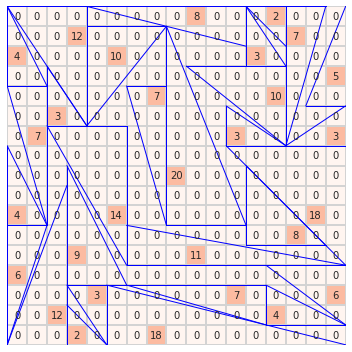

In [160]:
start = time.perf_counter()
test = Matrix(grid)
test.solve()
stop =  time.perf_counter()
print('Solution took {:0.4f} seconds'.format((stop-start)))
print('\nSolved Grid')
print('~~~~~~~~~~~')



In [41]:
url='https://www.janestreet.com/puzzles/solutions/october-2019-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The answer to this month’s puzzle is 31185 , and the completed grid is presented here.  Congratulations to everyone who got the correct answer this month!


### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/11/Oct19_Solution.png" width="300" >

4351438228406813274931200000